In [1]:
import sys
import os
import glob
sys.path.append(os.path.abspath('..'))

import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import pims
import trackpy as tp

from utils.utils import argnotnan, extract_frames_from_video, get_video_properties, get_contours_from_segmasks, get_contour_stats, rotate_masks_and_contours, rotate_masks_and_images, find_top_bottom_points_from_contours, export_selected_frames, normalize_contours_by_centers, shift_contours, autocorr_with_interpolation, transform_points_to_original_space
from utils.piv_utils import plot_bbox, get_trajectory_stats, construct_occupancy_map, construct_velocity_map, calculate_vorticity_binned, interpolate_2d_map, reindex_calculate_displacement_and_stack

plt.rcParams["figure.figsize"] = (6, 3)
plt.rcParams['axes.grid'] = False
plt.rcParams["axes.spines.top"] = True
plt.rcParams["axes.spines.right"] = True
plt.rcParams["font.size"] = 12
plt.rcParams["savefig.bbox"] = "tight"
plt.rcParams['figure.facecolor'] = 'white'

In [10]:
base_dir = '../data/results/'
subfolders = ['whirling', 'vortex']
csv_files = []
for subfolder in subfolders:
    search_pattern = os.path.join(base_dir, subfolder, '**', '*trajs.csv')
    csv_files.extend(glob.glob(search_pattern, recursive=True))

print(csv_files)

['../data/results/whirling/2024_0409_183417_103/2024_0409_183417_103_horizontal_central_trajs.csv', '../data/results/whirling/2024_0409_183417_103/2024_0409_183417_103_vertical_vortex_trajs.csv', '../data/results/vortex/2024_0412_123556_156/2024_0412_123556_156_vertical_central_trajs.csv', '../data/results/vortex/2024_0331_090303_001/2024_0331_090303_001_vertical_vortex_trajs.csv', '../data/results/vortex/2024_0408_074105_019/2024_0408_074105_019_horizontal_vortex_trajs.csv']


In [166]:
file_names = []
path_names = []

for nth in range(len(csv_files)):
    file_names.append(csv_files[nth].split("/")[-1])
    path_names.append("/".join(csv_files[nth].split("/")[:-1]))

print(file_names,"\n", path_names)
df = pd.DataFrame({"fn" : file_names, "pn" : path_names, "type" : ["c", "v", "c", "v", "v"], "col" : ["k", "salmon", "gray", "darkred", "red"]})
df

['2024_0409_183417_103_horizontal_central_trajs.csv', '2024_0409_183417_103_vertical_vortex_trajs.csv', '2024_0412_123556_156_vertical_central_trajs.csv', '2024_0331_090303_001_vertical_vortex_trajs.csv', '2024_0408_074105_019_horizontal_vortex_trajs.csv'] 
 ['../data/results/whirling/2024_0409_183417_103', '../data/results/whirling/2024_0409_183417_103', '../data/results/vortex/2024_0412_123556_156', '../data/results/vortex/2024_0331_090303_001', '../data/results/vortex/2024_0408_074105_019']


,fn,pn,type,col
0,2024_0409_183417_103_horizontal_central_trajs.csv,../data/results/whirling/2024_0409_183417_103,c,k
1,2024_0409_183417_103_vertical_vortex_trajs.csv,../data/results/whirling/2024_0409_183417_103,v,salmon
2,2024_0412_123556_156_vertical_central_trajs.csv,../data/results/vortex/2024_0412_123556_156,c,gray
3,2024_0331_090303_001_vertical_vortex_trajs.csv,../data/results/vortex/2024_0331_090303_001,v,darkred
4,2024_0408_074105_019_horizontal_vortex_trajs.csv,../data/results/vortex/2024_0408_074105_019,v,red


2024_0409_183417_103_horizontal_central_trajs.csv


/var/folders/l1/s9h8bddx0mv1bqzrqffsxhp00000gn/T/ipykernel_8935/440444863.py:41: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = df_exp.groupby('x_bin')['v_xy']


2024_0409_183417_103_vertical_vortex_trajs.csv
2024_0412_123556_156_vertical_central_trajs.csv
2024_0331_090303_001_vertical_vortex_trajs.csv


/var/folders/l1/s9h8bddx0mv1bqzrqffsxhp00000gn/T/ipykernel_8935/440444863.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = df_exp.groupby('y_bin')['v_xy']
/var/folders/l1/s9h8bddx0mv1bqzrqffsxhp00000gn/T/ipykernel_8935/440444863.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = df_exp.groupby('y_bin')['v_xy']
/var/folders/l1/s9h8bddx0mv1bqzrqffsxhp00000gn/T/ipykernel_8935/440444863.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the fu

2024_0408_074105_019_horizontal_vortex_trajs.csv


/var/folders/l1/s9h8bddx0mv1bqzrqffsxhp00000gn/T/ipykernel_8935/440444863.py:41: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = df_exp.groupby('x_bin')['v_xy']


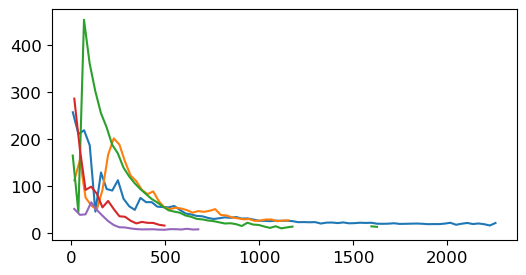

In [167]:

exp_medians = []
exp_bin_centers = []

for nth in range(len(df)):
    exp = int(nth)
    
    if "vertical" in df.loc[exp, "fn"]:
        df_exp = pd.read_csv(os.path.join(df.loc[exp, "pn"], df.loc[exp, "fn"]))
        print(df.loc[exp, "fn"])
        df_exp[["xnorm","ynorm","yrot_norm"]] = df_exp[["xnorm","ynorm","yrot_norm"]] / 60
        df_exp

        bin_width = 30
        bin_edges = np.arange(0, 3000, bin_width)
        if exp == 1:
            df_exp["y_bin"] = pd.cut((df_exp["yrot_norm"]-1100).abs(), bins=bin_edges)
        elif exp == 3:
            df_exp["y_bin"] = pd.cut((df_exp["yrot_norm"]-300).abs(), bins=bin_edges)
            
        else:
            df_exp["y_bin"] = pd.cut(df_exp["yrot_norm"], bins=bin_edges)

        grouped = df_exp.groupby('y_bin')['v_xy']
        medians = grouped.median()
        bin_centers = bin_edges[:-1] + np.diff(bin_edges) / 2
        
    
    elif "horizontal" in df.loc[exp, "fn"]:
        df_exp = pd.read_csv(os.path.join(df.loc[exp, "pn"], df.loc[exp, "fn"]))
        print(df.loc[exp, "fn"])
        df_exp[["xnorm","ynorm","xrot_norm"]] = df_exp[["xnorm","ynorm","xrot_norm"]] / 60
        df_exp

        bin_width = 30
        bin_edges = np.arange(0, 3000, bin_width)
        if exp == 4:
            df_exp["x_bin"] = pd.cut((df_exp["xrot_norm"]-600).abs(), bins=bin_edges)
        else:
            df_exp["x_bin"] = pd.cut(df_exp["xrot_norm"], bins=bin_edges)

        grouped = df_exp.groupby('x_bin')['v_xy']
        medians = grouped.median()
        bin_centers = bin_edges[:-1] + np.diff(bin_edges) / 2
    
    if exp == 0:
        bin_centers = bin_centers * -1
        bin_centers = bin_centers - np.min(bin_centers)  / 1.22
    elif exp == 2:
        bin_centers = bin_centers * -1
        bin_centers = bin_centers - np.min(bin_centers) / 1.8
        medians = medians / 2
        
    exp_medians.append(medians)
    exp_bin_centers.append(bin_centers)

plt.figure()
for medians, bins in zip(exp_medians, exp_bin_centers):
    plt.plot(bins, medians)

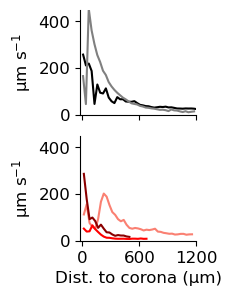

In [178]:
cols = df["col"].tolist()
type = df["type"].tolist()

fig, ax = plt.subplots(2,1,sharex=True,figsize=(1.5,3))

for nth, (medians, bins, c) in enumerate(zip(exp_medians, exp_bin_centers, cols)):
    if type[nth] == "c": # central
        ax[0].plot(bins, medians, "-", lw=1.5, color=c)
    elif type[nth] == "v": # vortex
        ax[1].plot(bins, medians, "-", lw=1.5, color=c)

ax[0].set(xlim=(-25, 1200), xticks=[0,600,1200],xticklabels=[], ylim=(0,450), ylabel="µm s$^{-1}$")
ax[1].set(xlim=(-25, 1200), xticks=[0,600,1200],ylim=(0,450),xticklabels=["0", "600", "1200"], xlabel="Dist. to corona (µm)", ylabel="µm s$^{-1}$")


#ax.set(ylim=(-15, point_count_bbox[3]), yticks=[0,500,1000], yticklabels=[0, .5, 1],ylabel="Y (mm)", xlabel="V. (µm s$^{-1}$)")
#ax.invert_yaxis()
for cax in ax:
    cax.spines[["top","right"]].set_visible(False)

fig.savefig(f"../data/results/whirling/summary_whirling_radial_dist{1}.jpg", dpi=600, bbox_inches="tight", edgecolor=None)

In [107]:
exp = 1
df_exp = pd.read_csv(os.path.join(df.loc[exp, "pn"], df.loc[exp, "fn"]))
df_exp.yrot_norm.min()

2447.04255319149

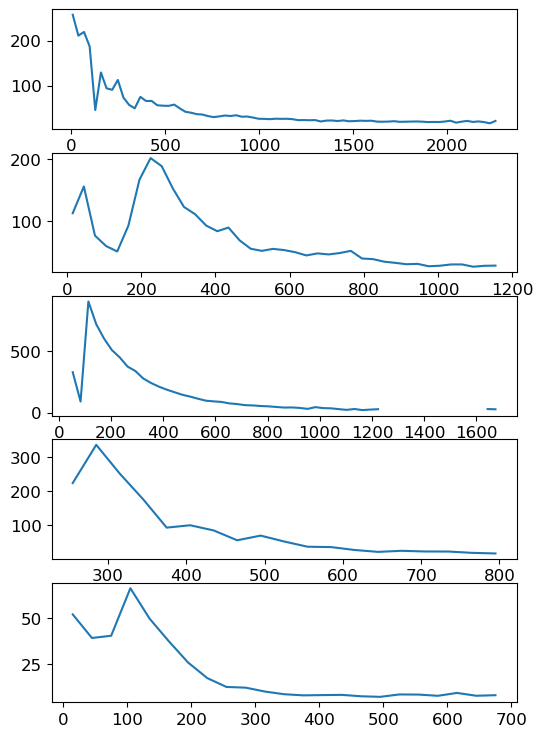

In [109]:
fig, ax = plt.subplots(len(exp_medians),1,figsize=(6,9))
for nth, (medians, bins) in enumerate(zip(exp_medians, exp_bin_centers)):
    ax[nth].plot(bins, medians)

In [54]:
"vertical" in df.loc[1, "fn"]  #.contains("vertical")

True

<BarContainer object of 99 artists>

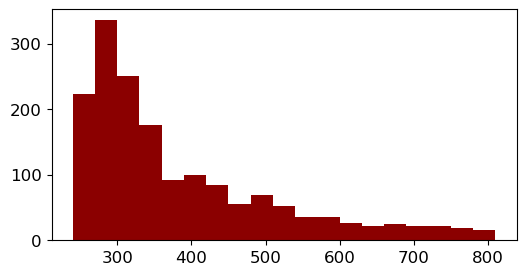

In [47]:

fig, ax = plt.subplots(figsize=(6,3))
plt.bar(bin_centers, medians, width=bin_width, color="darkred", zorder=2) # [::-1]
#plot_bbox([0, 200, 1670, 1710], c="b", ax=ax)
#ax.set(ylim=(-15, point_count_bbox[3]), yticks=[0,500,1000], yticklabels=[0, .5, 1],ylabel="Y (mm)", xlabel="V. (µm s$^{-1}$)")
#ax.invert_yaxis()
#ax.spines[["top","right"]].set_visible(False)

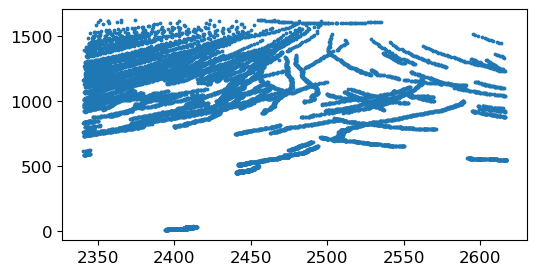

In [35]:
plt.scatter(df_exp["xnorm"],df_exp["ynorm"], s=3) #tp.plot_traj(df_exp)

In [41]:
read_in_paths = "../data/results/vortex/"
read_in_filenames = "2024_0412_123556_156.MP4"
traj_filename = "trajs_1800_frames.csv"

df = pd.read_csv(os.path.join(read_in_paths, os.path.splitext(read_in_filenames)[0], traj_filename))
df

,y,x,mass,size,ecc,signal,raw_mass,ep,frame,particle
0,486.267647,745.676471,132.488570,1.427668,0.177910,16.755907,-4845.2205,-0.480746,0,1
1,484.577381,148.166667,65.464941,1.594261,0.206180,7.014101,-5734.2920,-0.302427,0,2
2,485.051491,1012.588076,143.789066,1.754591,0.430690,13.638529,-3992.8292,-1.105930,0,3
3,482.382979,455.914894,36.629193,1.031421,0.256472,7.403773,-5894.2920,-0.283502,0,5
4,480.781553,953.728155,80.272487,1.374172,0.135691,9.741807,-4540.8762,-0.602317,0,6
...,...,...,...,...,...,...,...,...,...,...
2196550,272.592998,1108.722101,169.950962,1.308949,0.166759,27.891296,-3713.3669,-1.510918,1799,43516
2196551,272.419689,879.989637,71.773601,1.208776,0.045665,13.387822,-4557.7272,-0.545341,1799,50537
2196552,271.735955,1046.924157,132.390684,1.547924,0.288731,14.875358,-3670.1767,-1.661387,1799,14147
2196553,272.391803,1021.557377,226.849206,1.503548,0.258893,26.403760,-3757.1111,-1.383966,1799,49456


In [42]:
#norm_centers = list(df_top_bot[["top_x", "top_y"]].itertuples(index=False, name=None))

# change of x and y
df["dx"] = df.groupby(by="particle")["x"].transform(lambda x: x.diff())
df["dy"] = df.groupby(by="particle")["y"].transform(lambda y: y.diff())
df["v"] = np.sqrt(df["dx"] ** 2 + df["dy"] ** 2)
df["acc"] = np.sqrt(df["dx"].diff() ** 2 + df["dy"].diff() ** 2)
#df["acc"] = df.groupby(by="particle")["v"].transform(lambda v: v.diff())
#


In [44]:
df_ = df.dropna(subset="acc").sort_values("particle")
unique_prts = df_["particle"].unique()
df_

,y,x,mass,size,ecc,signal,raw_mass,ep,frame,particle,dx,dy,v,acc
928941,407.789157,772.680723,129.456200,1.317171,0.091873,19.106487,-4950.4864,-0.435646,803,1,0.392932,-0.141076,0.417490,0.337476
1066522,403.395480,780.290960,136.794359,1.382906,0.080201,17.389113,-4989.8239,-0.423414,916,1,0.000000,0.000000,0.000000,0.619610
625134,423.473118,760.129032,255.561925,1.643308,0.392145,26.694640,-4609.1029,-0.557103,544,1,0.000000,0.000000,0.000000,0.599152
161646,469.391629,747.849028,265.308032,1.579484,0.249093,28.949905,-4777.4023,-0.506193,141,1,-0.005138,-0.002716,0.005812,0.369362
1188057,400.460000,788.835000,78.796542,1.358308,0.084543,10.243550,-5027.8638,-0.411999,1015,1,0.538883,-0.083689,0.545343,0.476138
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2164102,148.245714,543.000000,64.073715,1.594634,0.555562,8.421117,-5410.7977,-0.331454,1773,52586,0.000000,0.000000,0.000000,0.103266
2176898,148.480620,547.534884,47.971445,1.320676,0.481017,7.437433,-5467.6227,-0.322847,1783,52586,0.428634,0.074370,0.435038,0.617814
2184193,147.434783,548.081522,69.004338,1.416134,0.287993,9.375589,-5444.6227,-0.326255,1789,52586,0.000000,0.000000,0.000000,0.038730
2187776,147.428571,548.079365,69.274788,1.419814,0.290165,9.529865,-5444.6227,-0.326120,1792,52586,0.000000,0.000000,0.000000,0.005028


In [ ]:
# group according to particle
grouped = df.groupby("particle").apply(lambda x: x[["x", "y", "v", "frame"]].to_numpy())
groups = {category: {"x": values.T[0], "y": values.T[1], "v": values.T[2], "frame": values.T[3]} for category, values in grouped.items()}

(0.0, 150.0)

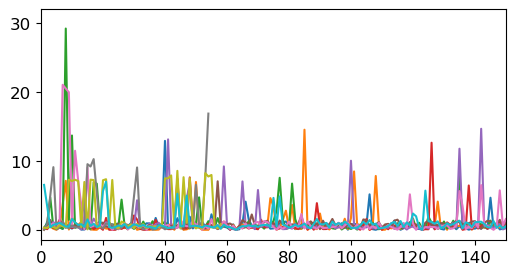

In [54]:
for prt in unique_prts[:10]:
    fa = df_.loc[df_.particle == prt, ["frame", "acc"]]
    f, a = fa.sort_values("frame").T.values
    plt.plot(f, a)
plt.xlim(0,150)

In [69]:
print(len(df_.loc[df_.acc > 10, "particle"].unique()), len(unique_prts))
prts_to_remove = df_.loc[df_.acc > 10, "particle"].unique()
df_clean = df_[~df_.particle.isin(prts_to_remove)]
print(len(df_clean.particle.unique()))

7862 11581
3719


(0.0, 30000.0)

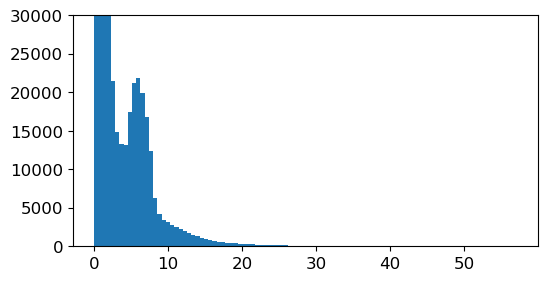

In [67]:
plt.hist(df_.acc.values, bins=100);
plt.ylim(0, 30000)

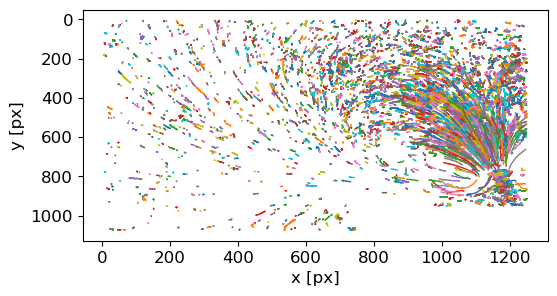

<Axes: xlabel='x [px]', ylabel='y [px]'>

In [70]:
tp.plot_traj(df_clean)

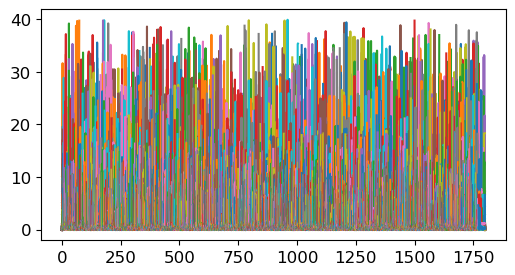

In [33]:
vl = []
for g, val in groups.items():
    plt.plot(val["frame"], argnotnan(val["v"]))
#plt.plot(vl[5].T)